In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation, FFMpegWriter  
import datetime
import geopandas

In [2]:
# Want to see if I can find anything regarding cross province infections

patient = pd.read_csv("./data/PatientInfo.csv", index_col="patient_id")

# drop columns that I don't need for this
patient = patient[["province", "infected_by", "confirmed_date"]]

# infected_by has some dirty data in it, identifying them here
patient.index = patient.index.astype(str)

patient[patient.infected_by.notnull() & ~patient.infected_by.isin(patient.index.values)]

,province,infected_by,confirmed_date
patient_id,,,
1000000003,Seoul,2002000001,2020-01-30
1000000062,Seoul,2017000005,2020-02-28
5000000022,Jeollabuk-do,"1500000050, 1500000055",2020-06-17
5100000022,Jeollanam-do,12702,2020-06-27
5100000023,Jeollanam-do,12702,2020-06-27
6100000034,Gyeongsangnam-do,6100000384,2020-02-26
6100000035,Gyeongsangnam-do,6100000384,2020-02-26
6100000036,Gyeongsangnam-do,6100000384,2020-02-26


In [3]:
# Was able to find the proper fix for patient_id 1000000003
# https://www.straitstimes.com/asia/east-asia/wuhan-virus-south-korea-reports-first-local-human-to-human-transmission
patient.loc["1000000003"].infected_by = "2000000001"

# 1000000062 case was difficult to find any info on, and variants of 2017000005 didn't result in any patient
# ids with reasonable dates.  I decided to convert this into a NaN
patient.loc["1000000062"].infected_by = np.nan

# 5000000022 was simple to fix, this is the only case where there are 2 infected_by, and both 1500000050 and
# 1500000055 have the same province and infection_case, which means that the graph wouldn't be affected if we
# picked one
patient.loc["5000000022"].infected_by = "1500000050"

# 5100000022 and 5100000023, no idea how to fix these.  There are 2 options: 1. Attribute it to 5100000021 as
# it's the only other local case in a reasonable time frame, or, 2. Remove the attribution.  I will do 2 here.
patient.loc["5100000022"].infected_by = np.nan
patient.loc["5100000023"].infected_by = np.nan
patient.loc["5100000022"].infection_case = "etc"
patient.loc["5100000023"].infection_case = "etc"

# The last 3 patients in Gyeongsangnam-do were amongst a huge list of people that were tested in affiliation
# with the Shincheonji Church or in contact with them.  Seeing that members of the church were likely to be
# tagged with infection_case = Shincheonji Church, I opted to assign them to be infected by a confirmed case
# from the Shincheonji Church, rather than assigning them to the group.  Note: There was also a few affilited
# with Geochang Church but these were the people confirmed or showed symtoms in Geochang-gun, so I ruled that
# out.  Might be wrong but Shincheonji Church were responsible for majority of the spread during this period
# that adding 3 cases to their name will not be significant anyways, sorry patient # 6100000028!

patient.loc["6100000034"].infected_by = "6100000028"
patient.loc["6100000035"].infected_by = "6100000028"
patient.loc["6100000036"].infected_by = "6100000028"

# This should be empty now:
patient[patient.infected_by.notnull() & ~patient.infected_by.isin(patient.index.values)]

,province,infected_by,confirmed_date
patient_id,,,


In [4]:
cross_province_spread = patient.merge(patient, how="left", right_index=True, left_on="infected_by")
cross_province_spread = cross_province_spread[(cross_province_spread.province_x != cross_province_spread.province_y) & cross_province_spread.province_y.notnull()].sort_values(by="confirmed_date_x")
cross_province_spread = cross_province_spread.rename(columns={"province_y": "from_province", "province_x": "to_province", "confirmed_date_x": "spread_date"}).reset_index()
cross_province_spread = cross_province_spread[["from_province", "to_province", "spread_date"]]
cross_province_spread["spread_date"] = cross_province_spread.spread_date.astype("datetime64[D]")

# cross_province_spread = cross_province_spread[["spread_date","latitude_x","longitude_x","latitude_y","longitude_y"]]

cross_province_spread

,from_province,to_province,spread_date
0,Gyeonggi-do,Seoul,2020-01-30
1,Gwangju,Jeollanam-do,2020-02-06
2,Daegu,Gyeongsangbuk-do,2020-02-19
3,Daegu,Gyeonggi-do,2020-02-21
4,Seoul,Gyeonggi-do,2020-02-22
...,...,...,...
180,Daejeon,Chungcheongnam-do,2020-06-24
181,Daejeon,Jeollabuk-do,2020-06-26
182,Seoul,Gyeonggi-do,2020-06-26
183,Gwangju,Jeollabuk-do,2020-06-28


In [5]:
# 185 cases of movement between provinces

In [6]:
# Now let's get daily cases of each province, it'll be interesting to see if local cases increases after
# virus spreads from province to province.

province = pd.read_csv("./data/TimeProvince.csv")

# only use the useful columns
province = province[["date", "province", "confirmed"]]
province["date"] = province.date.astype("datetime64[D]")

province = province.pivot(index="date", columns="province", values="confirmed")
province = (province - province.shift(1))[1:]
province = province.unstack().reset_index().rename(columns={0:"new_cases"})
province["new_cases"] = province.new_cases.clip(lower=0)
province

,province,date,new_cases
0,Busan,2020-01-21,0.0
1,Busan,2020-01-22,0.0
2,Busan,2020-01-23,0.0
3,Busan,2020-01-24,0.0
4,Busan,2020-01-25,0.0
...,...,...,...
2749,Ulsan,2020-06-26,0.0
2750,Ulsan,2020-06-27,0.0
2751,Ulsan,2020-06-28,0.0
2752,Ulsan,2020-06-29,0.0


<AxesSubplot:xlabel='date_diff'>

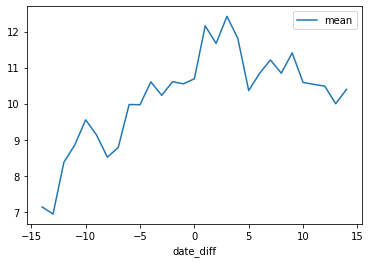

In [7]:
df = cross_province_spread.reset_index().merge(province, left_on="to_province", right_on="province")
df = df.merge(province, left_on=["province","spread_date"],right_on=["province","date"])
df["date_diff"] = (df.date_x - df.date_y).astype('timedelta64[D]')
df = df[df.date_diff.between(-14,14)]
df = df[["index","date_diff","new_cases_x"]]
df = df.pivot(index="index", columns="date_diff", values="new_cases_x")
(df.describe().T)[["mean"]].plot()

Hmm there seems to be an upward trend, but is this any different than any normal days? Do we see an uptick over 4 weeks all the time?

<AxesSubplot:xlabel='date_diff'>

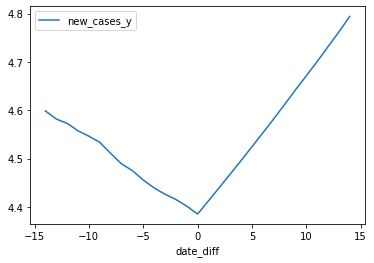

In [8]:
all_df = province.groupby(by="date").mean().reset_index()
all_df['key'] = 0
all_df = all_df.merge(all_df, how='left', left_on="key", right_on="key")
all_df["date_diff"] = (all_df.date_y - all_df.date_x).astype('timedelta64[D]')
all_df = all_df[all_df.date_diff.between(-14,14)]
all_df = all_df[["date_diff","new_cases_y"]]
all_df = all_df.groupby(by="date_diff").mean()
all_df.plot()

Nope, doesn't look like it! (Average across all days SHOULD be pretty linear unless your start/end data is very different :P)

How about FROM province?

<AxesSubplot:xlabel='date_diff'>

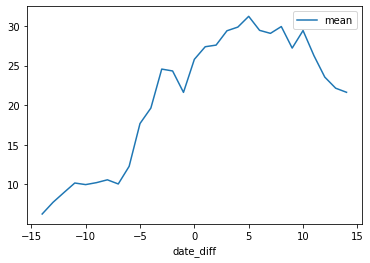

In [9]:
f_df = cross_province_spread.reset_index().merge(province, left_on="from_province", right_on="province")
f_df = f_df.merge(province, left_on=["province","spread_date"],right_on=["province","date"])
f_df["date_diff"] = (f_df.date_x - f_df.date_y).astype('timedelta64[D]')
f_df = f_df[f_df.date_diff.between(-14,14)]
f_df = f_df[["index","date_diff","new_cases_x"]]
f_df = f_df.pivot(index="index", columns="date_diff", values="new_cases_x")
(f_df.describe().T)[["mean"]].plot()

<AxesSubplot:xlabel='date_diff'>

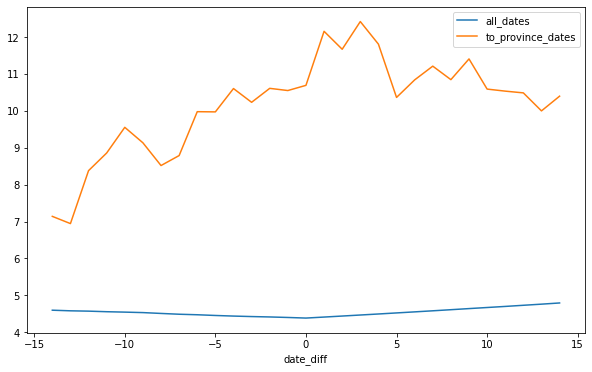

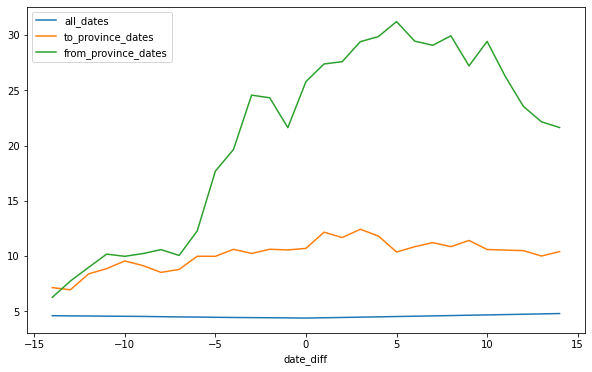

In [10]:
compare_df = pd.concat([all_df, (df.describe().T)[["mean"]]], axis=1)
compare_df = compare_df.rename(columns={"new_cases_y":"all_dates","mean":"to_province_dates"})
compare_df.plot(figsize=(10,6))
compare_df = pd.concat([compare_df, (f_df.describe().T)[["mean"]]], axis=1)
compare_df = compare_df.rename(columns={"new_cases_y":"all_dates","mean":"from_province_dates"})
compare_df.plot(figsize=(10,6))

I was surprised to find nothing too interesting in regards to the "to_province" data, but "from_province" turned out to be interesting.  On average, people are much more likely to spread cross-province around 7 days after an increase of cases.  This actually makes a lot of sense because people may not be as careful when a new outbreak hits when there are very few cases.  Factor in the incubation period and you'd end up with people unknowingly spreading COVID around.  I wonder if this applies to non-cross-province infections as well. Hm......